# Dynamic position applied forces on skateboard

In [32]:
# import libraries
import pickle as pkl
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length
lbr = sym.symbols('l_{wheels}') # length to reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia
rF_FF, rF_BF = sym.symbols(['r_{F_{FF}}','r_{F_{BF}}']) # distance of feet from COM. 

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

# forces
GRF_BW,GRF_FW = sym.symbols(['GRF_{BW}','GRF_{FW}']) # ground reaction forces
F_BFx,F_BFy = sym.symbols(['F_{BFx_{sb}}','F_{BFy_{sb}}']) # back foot applied forces
F_FFx,F_FFy = sym.symbols(['F_{FFx_{sb}}','F_{FFy_{sb}}']) # front foot applied forces

# Unpickle stored EOMs
infile = open('skateboard_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs = data['EOMs_Fsb']

# display(sym.solve(EOMs, [ddq[0],ddq[1],ddq[2]]))

In [33]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,hb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            rF_BF,rF_FF,
            F_BFx,F_BFy,F_FFx,F_FFy,
            GRF_BW,GRF_FW]
            
lambEOMx   = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOMy   = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOMthb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])

In [34]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 50
N1 = 10 # tilt back
N2 = 45 # landing
N3 = 50 # steady
m.N = RangeSet(N)

hm  = 0.01 #master timestep

DOFs = ['x','y','thb'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BFx','BFy','FFx','FFy'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

rFs = ['BF','FF'] # front foot, backfoot
m.rFs = Set(initialize = rFs) 

GRFs = ['BW','FW'] # front wheel, back wheel
m.GRFs = Set(initialize = GRFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 2.0) # mass of board
m.lb = Param(initialize = 0.80) # length of board
m.lbr = Param(initialize = 0.45) # length between wheels lb-(14.3+3)*2
m.hb = Param(initialize = 0.09) # board clearance
m.etail = Param(initialize = -0.6) #coefficient of restitution of tail

m.Inb = Param(initialize = 1/12*m.mb*m.lb**2) # moment of inertia about centre

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# forces
m.F = Var(m.N, m.Fs, bounds = (-4.0, 4.0)) # Force from front foot > 0
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, 20.0)) # Ground reaction force on back wheel

# radius of applied forces from COM
m.rF = Var(m.N, m.rFs, bounds = (0.5*m.lbr, 0.5*m.lb))

# auxillary variables
m.ptail = Var(m.N, m.DOF) # back of board
m.pnose = Var(m.N, m.DOF) # front of board
m.pbackwheel = Var(m.N, m.DOF) # position of backwheel
m.pfrontwheel = Var(m.N, m.DOF) # position of frontwheel
m.vtail = Var(m.N, m.DOF) # velocity of back of board

def def_ptail(m,n,dof):
    if dof == 'x':
        return m.ptail[n, 'x'] == m.q[n,'x'] - 0.5*m.lb*cos(m.q[n,'thb'])
    if dof == 'y':
        return m.ptail[n, 'y'] == m.q[n,'y'] - 0.5*m.lb*sin(m.q[n,'thb']) 
    else:
        return Constraint.Skip
m.def_ptail = Constraint(m.N, m.DOF,rule = def_ptail)

def def_pnose(m,n,dof):
    if dof == 'x':
        return m.pnose[n, 'x'] == m.q[n,'x'] + 0.5*m.lb*cos(m.q[n,'thb'])
    if dof == 'y':
        return m.pnose[n, 'y'] == m.q[n,'y'] + 0.5*m.lb*sin(m.q[n,'thb']) 
    else:
        return Constraint.Skip
m.def_pnose = Constraint(m.N, m.DOF,rule = def_pnose)

def def_pbackwheel(m,n,dof):
    if dof == 'x':
        return m.pbackwheel[n, 'x'] == m.q[n,'x']-0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    if dof == 'y':
        return m.pbackwheel[n, 'y'] == m.q[n,'y']-0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pbackwheel = Constraint(m.N, m.DOF,rule = def_pbackwheel)

def def_pfrontwheel(m,n,dof):
    if dof == 'x':
        return m.pfrontwheel[n, 'x'] == m.q[n,'x']+0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    if dof == 'y':
        return m.pfrontwheel[n, 'y'] == m.q[n,'y']+0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pfrontwheel = Constraint(m.N, m.DOF,rule = def_pfrontwheel)

def def_vtail(m,n,dof):
    if dof == 'y':
        return m.vtail[n, 'y'] == m.dq[n,'y']-m.dq[n,'thb']*0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_vtail = Constraint(m.N, m.DOF,rule = def_vtail)

# bound variables
for n in range(1,N+1):
    m.pnose[n,'y'].setlb(0.0)
    m.ptail[n,'y'].setlb(0.0)
    m.pbackwheel[n,'y'].setlb(0.0)
    m.pfrontwheel[n,'y'].setlb(0.0)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thb'].setlb(-np.pi/2)
    m.F[n,'BFy'].setlb(0.0)
    m.F[n,'FFy'].setlb(0.0)

In [35]:
# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        if (n == N1 and dof == 'y'):
            return m.dq[n,'y'] == m.etail*m.vtail[n-1,'y'] +  m.dq[n-1,'y'] + hm*m.h[n]*m.ddq[n-1,'y']
        else:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:    
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [36]:
# -----------------------------------------------------------------------------------------------------------------------------
# EOMs 
# -----------------------------------------------------------------------------------------------------------------------------
BW = 100 #m.g.value*m.mb.value

def EOMx(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               BW*m.F[n,'BFx'], BW*m.F[n,'BFy'], BW*m.F[n,'FFx'], BW*m.F[n,'FFy'], 
               BW*m.GRF[n,'BW'], BW*m.GRF[n,'FW']]
    return lambEOMx(*var_list) == 0
m.EOMx = Constraint(m.N, rule = EOMx)

def EOMy(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               BW*m.F[n,'BFx'], BW*m.F[n,'BFy'], BW*m.F[n,'FFx'], BW*m.F[n,'FFy'], 
               BW*m.GRF[n,'BW'], BW*m.GRF[n,'FW']]
    return lambEOMy(*var_list) == 0
m.EOMy = Constraint(m.N, rule = EOMy)

def EOMthb(m,n):
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               BW*m.F[n,'BFx'], BW*m.F[n,'BFy'], BW*m.F[n,'FFx'], BW*m.F[n,'FFy'], 
               BW*m.GRF[n,'BW'], BW*m.GRF[n,'FW']] 
    return lambEOMthb(*var_list) == 0
m.EOMthb = Constraint(m.N, rule = EOMthb)

In [37]:
# -----------------------------------------------------------------------------------------------------------------------------
# Contact Forces
# -----------------------------------------------------------------------------------------------------------------------------

ground_constraints = ['contact_BW','contact_FW']
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# ground contact complemetarity  
def ground_contact(m,n,gc):
    if n < N:
        if gc == 'contact_FW':
            return m.ground_penalty[n,'contact_FW'] == m.pfrontwheel[n+1,'y']*m.GRF[n,'FW'] 
        elif gc == 'contact_BW':
            return m.ground_penalty[n,'contact_BW'] == m.pbackwheel[n+1,'y']*m.GRF[n,'BW']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, m.ground_constraints, rule = ground_contact)   
    
for grf in GRFs:
    m.GRF[N, grf].fix(0.0)
    
for fs in Fs:
    m.F[N, fs].fix(0.0)

for rfs in rFs:
    m.rF[N, rfs].fix(0.5*m.lb)
    
for gnd in ground_constraints:
    m.ground_penalty[N, gnd].fix(0.0)
    m.ground_penalty[N, gnd].fix(0.0)

In [38]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------

# minimum force and penalties
def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    force_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc]
        for fs in Fs:
            force_sum += (m.F[n,fs]**2)*m.h[n]*hm 
    return force_sum + 1000*penalty_sum
#     return T+1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [39]:
# Standing, then tilt back

# Initial condition
m.pbackwheel[1,'x'].fix(0.0)
m.pbackwheel[1,'y'].fix(0.0)
m.q[1,'thb'].fix(0.0)

m.dq[1,'x'].fix(0.0)
m.dq[1,'y'].fix(0.0)
m.dq[1,'thb'].fix(0.0)

# end of tilt back phase
m.ptail[N1-1,'y'].fix(0.0)
# m.vtail[N1-1,'y'].fix(-0.5)

# # apex of flight
Nhw = round((N1+N2)/2)
m.pbackwheel[Nhw,'y'].setlb(0.4)
m.pfrontwheel[Nhw,'y'].setlb(0.4)
m.q[Nhw,'thb'].fix(0.0)

# landing
m.pbackwheel[N2,'y'].fix(0.0)
m.q[N2,'thb'].fix(0.0)

m.pbackwheel[N3,'y'].fix(0.0)
m.q[N3,'thb'].fix(0.0)

m.pbackwheel[N3,'x'].setub(0.5)

# for n in range(1,N+1):
# #     for fs in Fs:
# #          if fs == 'FFx' or fs == 'FFy':
# #                 m.F[n, fs].fix(0.0)
# #     m.F[n,'FFx'].fix(0.0)
# #     m.F[n,'FFy'].fix(0.0)
# #     m.F[n,'BFx'].fix(0.0)
#     m.rF[n,'FF'].fix(0.5*m.lb)
#     m.rF[n,'BF'].fix(0.5*m.lb)
    
#     for gc in ground_constraints:
#         m.ground_penalty[n,gc].setub(1e-6)
        

In [40]:
# m.rF.pprint()

In [41]:
# Solve -----------------------------------------------------------------------------------------------------------------------
# opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Nick/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 50000 # maximum number of iterations
opt.options["max_cpu_time"] = 10*60 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee=True) 

print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

Ipopt 3.12.9: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=50000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.9, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     3875
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1248

Total number of variables............................:     1428
                     variables with only lower bounds:      294
                variables with lower and upper bounds:      488
                     variables with only up

In [42]:
#m.ground_penalty.pprint()
#m.rF.pprint()

In [43]:
# h_ar[-1]

In [44]:
penalty_sum = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum += m.ground_penalty[n,gc].value
print(penalty_sum)
# m.ground_penalty.pprint()

5.854781775554244e-09


In [45]:
# m.ground_penalty.pprint()

In [46]:
maxForce = 0
maxGRF = 0
for i in range(1,N+1):
    for fs in Fs:
        if m.F[i,fs].value>maxForce:
            maxForce = m.F[i,fs].value
    for grf in GRFs:
        if m.GRF[i,grf].value is not None: 
            if m.GRF[i,grf].value>maxGRF:
                 maxGRF = m.GRF[i,grf].value


In [47]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

h_ar1 = [m.h[i]() for i in range (1,N+1)]
h_ar1[0] = 0
h_ar1 = hm*np.cumsum(np.asarray(h_ar1))

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1.25])
    ax.set_ylim([-0.5,1.0])
    
    MARKER_SIZE = 10
    
    #plot ground
    groundLx = -1
    groundLy = 0
    groundRx = 2
    groundRy = 0
    ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')
    
    #plot skateboard
    boardLx = m.ptail[i,'x'].value
    boardLy = m.ptail[i,'y'].value
    boardRx = m.pnose[i,'x'].value
    boardRy = m.pnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = m.pbackwheel[i,'x'].value
    leftwheelBottomy = m.pbackwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbr*cos(m.q[i,'thb'].value)+0.6*m.hb*sin(m.q[i,'thb'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbr*sin(m.q[i,'thb'].value)-0.6*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = m.pfrontwheel[i,'x'].value
    rightwheelBottomy = m.pfrontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbr*cos(m.q[i,'thb'].value)+0.6*m.hb*sin(m.q[i,'thb'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbr*sin(m.q[i,'thb'].value)-0.6*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot forces
    backforcex = m.q[i,'x'].value - m.rF[i,'BF'].value*cos(m.q[i,'thb'].value)
    backforcey = m.q[i,'y'].value - m.rF[i,'BF'].value*sin(m.q[i,'thb'].value)
    frontforcex = m.q[i,'x'].value + m.rF[i,'FF'].value*cos(m.q[i,'thb'].value)
    frontforcey = m.q[i,'y'].value + m.rF[i,'FF'].value*sin(m.q[i,'thb'].value)
    
    if maxForce!=0:
        magforceBFx = m.F[i,'BFx'].value/maxForce
        magforceBFy = m.F[i,'BFy'].value/maxForce
        magforceFFx = m.F[i,'FFx'].value/maxForce
        magforceFFy = m.F[i,'FFy'].value/maxForce 
        
#         magforceBFx = 1
#         magforceBFy = 1 
#         magforceFFx = 1
#         magforceFFy = 1 

        # Back foot x force
        pBFxx = backforcex - 0.5*magforceBFx*np.cos(m.q[i,'thb'].value)
        dpBFxx = 0.5*magforceBFx*np.cos(m.q[i,'thb'].value)
        pBFxy = backforcey - 0.5*magforceBFx*np.sin(m.q[i,'thb'].value)
        dpBFxy = 0.5*magforceBFx*np.sin(m.q[i,'thb'].value)

        # back foot y force
        pBFyx = backforcex - 0.5*magforceBFy*np.sin(m.q[i,'thb'].value)
        dpBFyx = 0.5*magforceBFy*np.sin(m.q[i,'thb'].value)
        pBFyy = backforcey + 0.5*magforceBFy*np.cos(m.q[i,'thb'].value)
        dpBFyy = -0.5*magforceBFy*np.cos(m.q[i,'thb'].value)

        ax.arrow(pBFxx, pBFxy, dpBFxx, dpBFxy, length_includes_head=True,head_width=abs(magforceBFx)*0.05,color='orange')
        ax.arrow(pBFyx, pBFyy, dpBFyx, dpBFyy, length_includes_head=True,head_width=abs(magforceBFy)*0.05,color='red')

        # front foot x force
        pFFxx = frontforcex - 0.5*magforceFFx*np.cos(m.q[i,'thb'].value)
        dpFFxx = 0.5*magforceFFx*np.cos(m.q[i,'thb'].value)
        pFFxy = frontforcey - 0.5*magforceFFx*np.sin(m.q[i,'thb'].value)
        dpFFxy = 0.5*magforceFFx*np.sin(m.q[i,'thb'].value)

        # front foot y force
        pFFyx = frontforcex - 0.5*magforceFFy*np.sin(m.q[i,'thb'].value)
        dpFFyx = 0.5*magforceFFy*np.sin(m.q[i,'thb'].value)
        pFFyy = frontforcey + 0.5*magforceFFy*np.cos(m.q[i,'thb'].value)
        dpFFyy = -0.5*magforceFFy*np.cos(m.q[i,'thb'].value)

        ax.arrow(pFFxx, pFFxy, dpFFxx, dpFFxy, length_includes_head=True,head_width=abs(magforceFFx)*0.05,color='orange')
        ax.arrow(pFFyx, pFFyy, dpFFyx, dpFFyy, length_includes_head=True,head_width=abs(magforceFFy)*0.05,color='red')

    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0
        
    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')

update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1, update, frames=range(1,N+1), interval=100, repeat=True)

plt.close(animate._fig)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [55]:
# m.rF.pprint()

In [56]:
import matplotlib.pyplot as plt

h_ar1 = [m.h[i]() for i in range (1,N+1)]
h_ar1[0] = 0
h_ar1 = hm*np.cumsum(np.asarray(h_ar1))

def make_discrete_plots(m,i,count):
    
    plt.rcParams.update({'font.size': 25}) # change font size
    
    f = plt.figure(figsize=(4, 4));
    ax = f.add_subplot(111) #create axes
    ax.set_aspect('equal')
    
    XLOW = m.q[i,'x'].value - 0.5
    XUP = m.q[i,'x'].value + 0.5
    
    ax.clear()
    ax.set_xlim([XLOW,XUP])
    ax.set_ylim([-0.5,1.0])
    
    MARKER_SIZE = 10
    
    #plot skateboard
    boardLx = m.ptail[i,'x'].value
    boardLy = m.ptail[i,'y'].value
    boardRx = m.pnose[i,'x'].value
    boardRy = m.pnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = m.pbackwheel[i,'x'].value
    leftwheelBottomy = m.pbackwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbr*cos(m.q[i,'thb'].value)+0.7*m.hb*sin(m.q[i,'thb'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbr*sin(m.q[i,'thb'].value)-0.7*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = m.pfrontwheel[i,'x'].value
    rightwheelBottomy = m.pfrontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbr*cos(m.q[i,'thb'].value)+0.7*m.hb*sin(m.q[i,'thb'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbr*sin(m.q[i,'thb'].value)-0.7*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot forces
    backforcex = m.q[i,'x'].value - m.rF[i,'BF'].value*cos(m.q[i,'thb'].value)
    backforcey = m.q[i,'y'].value - m.rF[i,'BF'].value*sin(m.q[i,'thb'].value)
    frontforcex = m.q[i,'x'].value + m.rF[i,'FF'].value*cos(m.q[i,'thb'].value)
    frontforcey = m.q[i,'y'].value + m.rF[i,'FF'].value*sin(m.q[i,'thb'].value)
    
    if maxForce!=0:
        magforceBFx = m.F[i,'BFx'].value/maxForce
        magforceBFy = m.F[i,'BFy'].value/maxForce
        magforceFFx = m.F[i,'FFx'].value/maxForce
        magforceFFy = m.F[i,'FFy'].value/maxForce 
        
#         magforceBFx = 1
#         magforceBFy = 1 
#         magforceFFx = 1
#         magforceFFy = 1 

        # Back foot x force
        pBFxx = backforcex - 0.5*magforceBFx*np.cos(m.q[i,'thb'].value)
        dpBFxx = 0.5*magforceBFx*np.cos(m.q[i,'thb'].value)
        pBFxy = backforcey - 0.5*magforceBFx*np.sin(m.q[i,'thb'].value)
        dpBFxy = 0.5*magforceBFx*np.sin(m.q[i,'thb'].value)

        # back foot y force
        pBFyx = backforcex - 0.5*magforceBFy*np.sin(m.q[i,'thb'].value)
        dpBFyx = 0.5*magforceBFy*np.sin(m.q[i,'thb'].value)
        pBFyy = backforcey + 0.5*magforceBFy*np.cos(m.q[i,'thb'].value)
        dpBFyy = -0.5*magforceBFy*np.cos(m.q[i,'thb'].value)

        ax.arrow(pBFxx, pBFxy, dpBFxx, dpBFxy, length_includes_head=True,head_width=abs(magforceBFx)*0.05,color='orange')
        ax.arrow(pBFyx, pBFyy, dpBFyx, dpBFyy, length_includes_head=True,head_width=abs(magforceBFy)*0.05,color='red')

        # front foot x force
        pFFxx = frontforcex - 0.5*magforceFFx*np.cos(m.q[i,'thb'].value)
        dpFFxx = 0.5*magforceFFx*np.cos(m.q[i,'thb'].value)
        pFFxy = frontforcey - 0.5*magforceFFx*np.sin(m.q[i,'thb'].value)
        dpFFxy = 0.5*magforceFFx*np.sin(m.q[i,'thb'].value)

        # front foot y force
        pFFyx = frontforcex - 0.5*magforceFFy*np.sin(m.q[i,'thb'].value)
        dpFFyx = 0.5*magforceFFy*np.sin(m.q[i,'thb'].value)
        pFFyy = frontforcey + 0.5*magforceFFy*np.cos(m.q[i,'thb'].value)
        dpFFyy = -0.5*magforceFFy*np.cos(m.q[i,'thb'].value)

        ax.arrow(pFFxx, pFFxy, dpFFxx, dpFFxy, length_includes_head=True,head_width=abs(magforceFFx)*0.05,color='orange')
        ax.arrow(pFFyx, pFFyy, dpFFyx, dpFFyy, length_includes_head=True,head_width=abs(magforceFFy)*0.05,color='red')
    
    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0
        
    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.3,0,magGRFBW*0.3, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.3,0,magGRFFW*0.3, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')
    
    #plot time
    xtext = round(m.q[i,'x'].value,3) 
    ytext = -0.4
#     txt = 't = ' + str(round(h_ar1[i-1],3)) +'s'
    txt = 'n = ' + str(i)
    ax.text(xtext, ytext, txt, horizontalalignment='center', fontsize=25)
    
    if count == 1:
        ax.axis('on')
    else:
        ax.axis('off')

In [60]:
count = 1
Nplot = 1
Nplot_up = N
Nsplot = [1,5,9,20,28,38,45,50]
# for n in range(Nplot,Nplot_up,1):
for n in Nsplot:
    make_discrete_plots(m,n,count)
    fig_name = 'plots\\design_2\\design_2_' + str(n) + '.png'
    plt.savefig(fig_name, format='png')
    plt.close()
    count +=1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

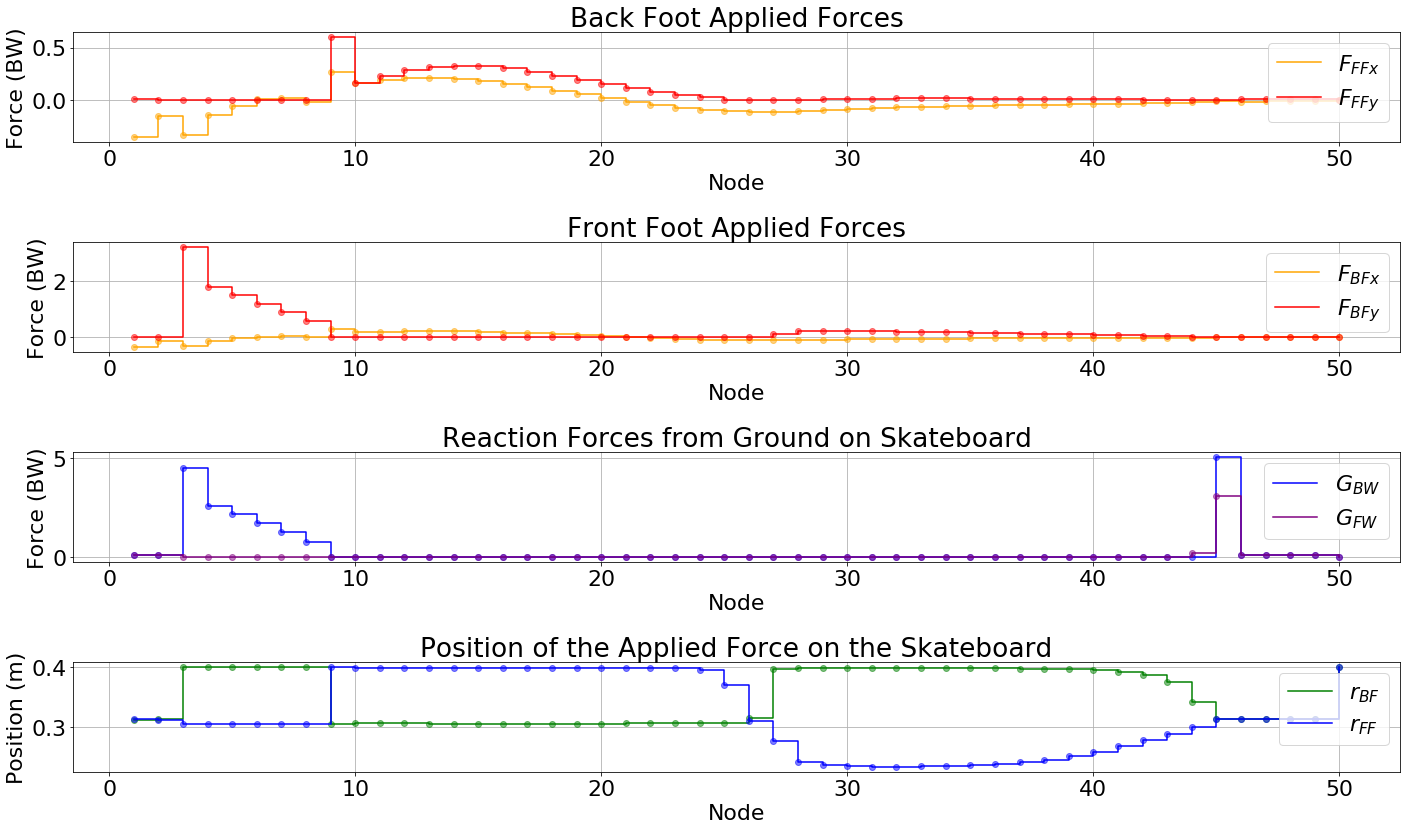

In [73]:
from matplotlib import colors as mcolors 

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Plot some of the variables
plt.rcParams.update({'font.size': 22}) # change font size

F_BFxar = [m.F[i,'BFx']() for i in range(Nplot,Nplot_up+1)]
F_FFxar  = [m.F[i,'FFx']() for i in range(Nplot,Nplot_up+1)]
F_BFyar = [m.F[i,'BFy']() for i in range(Nplot,Nplot_up+1)]
F_FFyar  = [m.F[i,'FFy']() for i in range(Nplot,Nplot_up+1)]
GRF_BWar = [m.GRF[i,'BW']() for i in range(Nplot,Nplot_up+1)]
GRF_FWar = [m.GRF[i,'FW']() for i in range(Nplot,Nplot_up+1)]
rF_BFar = [m.rF[i,'BF']() for i in range(Nplot,Nplot_up+1)]
rF_FFar = [m.rF[i,'FF']() for i in range(Nplot,Nplot_up+1)]

h_ar = h_ar1[Nplot-1:Nplot_up]

n_ar = np.linspace(1,N,N)

plt.figure(figsize=(20, 12))
plt.subplot(4,1,1)
plt.step(n_ar, F_FFxar,where='post',color = 'orange', label = r'$F_{FFx}$')
plt.plot(n_ar, F_FFxar, 'o', color='orange',alpha=0.5)
plt.step(n_ar, F_FFyar,where='post',color = 'red', label = r'$F_{FFy}$')
plt.plot(n_ar, F_FFyar, 'o', color='red',alpha=0.5)
plt.title('Back Foot Applied Forces')
plt.xlabel('Node')
plt.ylabel('Force (BW)')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(4,1,2)
plt.step(n_ar, F_BFxar,where='post',color = 'orange', label=r'$F_{BFx}$')
plt.plot(n_ar, F_BFxar, 'o', color = 'orange', alpha=0.5)
plt.step(n_ar, F_BFyar,where='post',color = 'red', label=r'$F_{BFy}$')
plt.plot(n_ar, F_BFyar, 'o', color='red',alpha=0.5)
plt.title('Front Foot Applied Forces')
plt.xlabel('Node')
plt.ylabel('Force (BW)')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(4,1,3)
plt.step(n_ar, GRF_BWar,where='post',color='blue',label = r'$G_{BW}$')
plt.plot(n_ar, GRF_BWar, 'o', color='blue', alpha=0.5)
plt.step(n_ar, GRF_FWar,where='post',color='purple',label = r'$G_{FW}$')
plt.plot(n_ar, GRF_FWar, 'o', color='purple',alpha=0.5)
plt.title('Reaction Forces from Ground on Skateboard')
plt.xlabel('Node')
plt.ylabel('Force (BW)')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(4,1,4)
plt.step(n_ar, rF_BFar,where='post',color='green',label = r'$r_{BF}$')
plt.plot(n_ar, rF_BFar, 'o', color='green', alpha=0.5)
plt.step(n_ar, rF_FFar,where='post',color='blue',label = r'$r_{FF}$')
plt.plot(n_ar, rF_FFar, 'o', color='blue', alpha=0.5)
plt.title('Position of the Applied Force on the Skateboard')
plt.xlabel('Node')
plt.ylabel('Position (m)')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.tight_layout()

fig_name = 'plots\\design_2\\design_2_' + str(n) + '.eps'
plt.savefig(fig_name, format='eps')
fig_name = 'plots\\design_2\\design_2_' + str(n) + '.svg'
plt.savefig(fig_name, format='svg')

In [52]:
# store all variables for extrapolation
from scipy.interpolate import interp1d

#initialize time dependent arrays
q_x_ar = np.zeros(N)
q_y_ar = np.zeros(N)
q_thb_ar = np.zeros(N)

ptail_x_ar = np.zeros(N)
ptail_y_ar = np.zeros(N)
pnose_x_ar = np.zeros(N)
pnose_y_ar = np.zeros(N)

pbackwheel_x_ar = np.zeros(N)
pbackwheel_y_ar = np.zeros(N)
pfrontwheel_x_ar = np.zeros(N)
pfrontwheel_y_ar = np.zeros(N)

F_BFx_ar = np.zeros(N)
F_BFy_ar = np.zeros(N)
F_FFx_ar = np.zeros(N)
F_FFy_ar = np.zeros(N)

rF_BF_ar = np.zeros(N)
rF_FF_ar = np.zeros(N)

GRF_FW_ar = np.zeros(N)
GRF_BW_ar = np.zeros(N)
h_ar = np.zeros(N)

# fill arrays with solver values
for i in range (1,N+1):
    q_x_ar[i-1]    = m.q[i,'x'].value
    q_y_ar[i-1]    = m.q[i,'y'].value
    q_thb_ar[i-1]  = m.q[i,'thb'].value

    ptail_x_ar[i-1] = m.ptail[i,'x'].value
    ptail_y_ar[i-1] = m.ptail[i,'y'].value
    pnose_x_ar[i-1] = m.pnose[i,'x'].value
    pnose_y_ar[i-1] = m.pnose[i,'y'].value
    
    pbackwheel_x_ar[i-1] = m.pbackwheel[i,'x'].value
    pbackwheel_y_ar[i-1] = m.pbackwheel[i,'y'].value
    pfrontwheel_x_ar[i-1] = m.pfrontwheel[i,'x'].value
    pfrontwheel_y_ar[i-1] = m.pfrontwheel[i,'y'].value
    
    F_BFx_ar[i-1] = m.F[i,'BFx'].value
    F_BFy_ar[i-1] = m.F[i,'BFy'].value
    F_FFx_ar[i-1] = m.F[i,'FFx'].value
    F_FFy_ar[i-1] = m.F[i,'FFy'].value
    
    rF_BF_ar[i-1]= m.rF[i,'BF'].value
    rF_FF_ar[i-1]= m.rF[i,'FF'].value
    
    GRF_FW_ar[i-1] = m.GRF[i,'FW'].value
    GRF_BW_ar[i-1] = m.GRF[i,'BW'].value
    
    h_ar[i-1] = m.h[i].value*hm

# calculate the time array. 
t_ar = np.cumsum(h_ar)

# caculate the interpolation functions.
f_x_interp = interp1d(t_ar, q_x_ar, kind='cubic')
f_y_interp = interp1d(t_ar, q_y_ar, kind='cubic')
f_thb_interp = interp1d(t_ar, q_thb_ar, kind='cubic')

f_ptail_x_interp = interp1d(t_ar, ptail_x_ar, kind='cubic')
f_ptail_y_interp = interp1d(t_ar, ptail_y_ar, kind='cubic')
f_pnose_x_interp = interp1d(t_ar, pnose_x_ar, kind='cubic')
f_pnose_y_interp = interp1d(t_ar, pnose_y_ar, kind='cubic')

f_pbackwheel_x_interp = interp1d(t_ar, pbackwheel_x_ar, kind='cubic')
f_pbackwheel_y_interp = interp1d(t_ar, pbackwheel_y_ar, kind='cubic')
f_pfrontwheel_x_interp = interp1d(t_ar, pfrontwheel_x_ar, kind='cubic')
f_pfrontwheel_y_interp = interp1d(t_ar, pfrontwheel_y_ar, kind='cubic')

f_F_BFx_interp = interp1d(t_ar, F_BFx_ar, kind='next')
f_F_BFy_interp = interp1d(t_ar, F_BFy_ar, kind='next')
f_F_FFx_interp = interp1d(t_ar, F_FFx_ar, kind='next')
f_F_FFy_interp = interp1d(t_ar, F_FFy_ar, kind='next')

f_rF_BF_interp = interp1d(t_ar, rF_BF_ar, kind='next')
f_rF_FF_interp = interp1d(t_ar, rF_FF_ar, kind='next')

f_GRF_FW_interp = interp1d(t_ar, GRF_FW_ar, kind='next')
f_GRF_BW_interp = interp1d(t_ar, GRF_BW_ar, kind='next')

# the desired time steps of 0.01s (100Hz)
Ts = hm
t_d = np.arange(hm, t_ar[-1], Ts)

# sample the interpolation functions at 50Hz.
q_x_interp = f_x_interp(t_d)
q_y_interp = f_y_interp(t_d)
q_thb_interp = f_thb_interp(t_d)

ptail_x_interp = f_ptail_x_interp(t_d)
ptail_y_interp = f_ptail_y_interp(t_d)
pnose_x_interp = f_pnose_x_interp(t_d)
pnose_y_interp = f_pnose_y_interp(t_d)

pbackwheel_x_interp = f_pbackwheel_x_interp(t_d)
pbackwheel_y_interp = f_pbackwheel_y_interp(t_d)
pfrontwheel_x_interp = f_pfrontwheel_x_interp(t_d)
pfrontwheel_y_interp = f_pfrontwheel_y_interp(t_d)

F_BFx_interp = f_F_BFx_interp(t_d)
F_BFy_interp = f_F_BFy_interp(t_d)
F_FFx_interp = f_F_FFx_interp(t_d)
F_FFy_interp = f_F_FFy_interp(t_d)

rF_BF_interp = f_rF_BF_interp(t_d)
rF_FF_interp = f_rF_FF_interp(t_d)

GRF_FW_interp = f_GRF_FW_interp(t_d)
GRF_BW_interp = f_GRF_BW_interp(t_d)

# number of samples
N_interp = len(t_d) 

In [53]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_title('0.3m, Complementary Constraints, Real Time')
    ax.set_xlim([-1,2])
    ax.set_ylim([-0.5,2.0])
    
    MARKER_SIZE = 6
    
    #plot ground
    groundLx = -1
    groundLy = 0
    groundRx = 2
    groundRy = 0
    ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')
    
    #plot skateboard
    boardLx = ptail_x_interp[i]
    boardLy = ptail_y_interp[i]
    boardRx = pnose_x_interp[i]
    boardRy = pnose_y_interp[i]
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = q_x_interp[i]-0.5*m.lbr*np.cos(q_thb_interp[i])
    leftwheelTopy = q_y_interp[i]-0.5*m.lbr*np.sin(q_thb_interp[i])
    leftwheelBottomx = pbackwheel_x_interp[i]
    leftwheelBottomy = pbackwheel_y_interp[i]
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot left wheel-wheel
    leftwheelx = q_x_interp[i]-0.5*m.lbr*cos(q_thb_interp[i])+0.6*m.hb*sin(q_thb_interp[i])
    leftwheely = q_y_interp[i]-0.5*m.lbr*sin(q_thb_interp[i])-0.6*m.hb*cos(q_thb_interp[i])
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot right wheel
    rightwheelTopx = q_x_interp[i]+0.5*m.lbr*np.cos(q_thb_interp[i])
    rightwheelTopy = q_y_interp[i]+0.5*m.lbr*np.sin(q_thb_interp[i])
    rightwheelBottomx = pfrontwheel_x_interp[i]
    rightwheelBottomy = pfrontwheel_y_interp[i]
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
    #plot right wheel-wheel
    rightwheelx = q_x_interp[i]+0.5*m.lbr*cos(q_thb_interp[i])+0.6*m.hb*sin(q_thb_interp[i])
    rightwheely = q_y_interp[i]+0.5*m.lbr*sin(q_thb_interp[i])-0.6*m.hb*cos(q_thb_interp[i])
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
#     #plot forces
#     backforcex = q_x_interp[i] - rF_BF_interp[i]*cos(q_thb_interp[i])
#     backforcey = q_y_interp[i] - rF_BF_interp[i]*sin(q_thb_interp[i])
#     frontforcex = q_x_interp[i] + rF_FF_interp[i]*cos(q_thb_interp[i])
#     frontforcey = q_y_interp[i] + rF_FF_interp[i]*sin(q_thb_interp[i])
    
#     if maxForce!=0:
#         magforceBFy = F_BFy_interp[i]/maxForce
#         magforceFFy = F_FFy_interp[i]/maxForce 
#         magforceBFx = F_BFx_interp[i]/maxForce
#         magforceFFx = F_FFx_interp[i]/maxForce         
    
#     ax.arrow(backforcex, backforcey+magforceBFy*0.5,0,-magforceBFy*0.5, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
#     ax.arrow(frontforcex, frontforcey+magforceFFy*0.5,0,-magforceFFy*0.5, length_includes_head=True,head_width=magforceFFy*0.05,color='red')

#     ax.arrow(backforcex-magforceBFx*0.5, backforcey,magforceBFx*0.5,0, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
#     ax.arrow(frontforcex-magforceFFx*0.5,frontforcey,magforceFFx*0.5,0, length_includes_head=True,head_width=magforceFFy*0.05,color='red')
    
#     #plot GRF's
#     if (GRF_BW_interp[i] is not None) and (GRF_BW_interp[i]!=0.0):
#         magGRFBW = GRF_BW_interp[i]/maxGRF
#     else: 
#         magGRFBW = 0
#     if (GRF_FW_interp[i] is not None) and (GRF_FW_interp[i]!=0.0):
#         magGRFFW = GRF_FW_interp[i]/maxGRF
#     else: 
#         magGRFFW = 0
        
#     backGRFx = leftwheelBottomx
#     backGRFy = leftwheelBottomy
#     frontGRFx = rightwheelBottomx
#     frontGRFy = rightwheelBottomy        

#     ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
#     ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')

update = lambda i: plot_board(i,m,ax1) #lambdify update function

# animate it - interval is in ms
animate = ani.FuncAnimation(fig1,update,frames=range(0,N_interp),interval=Ts*1000,repeat=True)

plt.close(animate._fig)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
